# Part 1. Predicting latencies to ap-east-1

In [1]:
import numpy as np
import pandas as pd

### Data Input

In [2]:
src_dest_df = pd.read_parquet('src_dest_df.parquet')
src_dest_df = src_dest_df.loc[src_dest_df.cloud_geo_iso1 != 'AWS.ap-east-1'] # removing this from training so that you can use it for testing/validation later 
src_dest_df.timestamp = pd.to_datetime(src_dest_df.timestamp)

sorted(src_dest_df.cloud_geo_iso1.unique())

['AWS.ap-northeast-1',
 'AWS.ap-northeast-2',
 'AWS.ap-south-1',
 'AWS.ap-southeast-1',
 'AWS.ap-southeast-2',
 'AWS.ca-central-1',
 'AWS.eu-central-1',
 'AWS.eu-north-1',
 'AWS.eu-west-1',
 'AWS.eu-west-2',
 'AWS.eu-west-3',
 'AWS.sa-east-1',
 'AWS.us-east-1',
 'AWS.us-east-2',
 'AWS.us-west-1',
 'AWS.us-west-2']

In [3]:
src_dest_df.head()

,timestamp,cloud_geo_iso1,cloud_geo_iso2,latency_ms,packet_loss_percent
66,2020-01-01 11:00:00+00:00,AWS.eu-west-1,AWS.ap-northeast-2,124.20,0.0
67,2020-01-01 02:00:00+00:00,AWS.eu-west-1,AWS.ap-southeast-2,131.80,0.0
68,2020-01-08 04:00:00+00:00,AWS.eu-west-1,AWS.ap-northeast-2,123.75,0.0
69,2020-01-17 00:00:00+00:00,AWS.eu-west-1,AWS.eu-west-2,6.35,0.0
70,2020-01-18 03:00:00+00:00,AWS.eu-west-1,AWS.us-west-1,72.35,0.0


<AxesSubplot:>

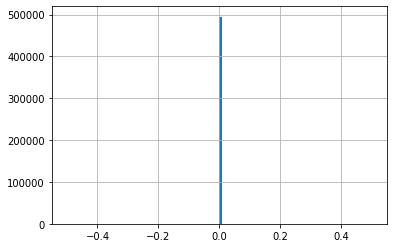

In [4]:
src_dest_df.packet_loss_percent.hist(bins = 100)

In [5]:
src_dest_df.timestamp.describe()

/tmp/ipykernel_17616/2947770902.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  src_dest_df.timestamp.describe()


count                        495015
unique                         2185
top       2020-01-01 11:00:00+00:00
freq                            238
first     2019-12-31 23:00:00+00:00
last      2020-03-31 23:00:00+00:00
Name: timestamp, dtype: object

In [6]:
src_dest_df.shape

(495015, 5)

In [7]:
aws_region_df = pd.read_pickle('region_geo_lookup_aws.pkl')
aws_region_df.region_name.unique()

array(['AWS.us-east-1', 'AWS.us-east-2', 'AWS.us-west-1', 'AWS.us-west-2',
       'AWS.eu-west-1', 'AWS.eu-west-2', 'AWS.eu-west-3',
       'AWS.eu-central-1', 'AWS.sa-east-1', 'AWS.ap-southeast-1',
       'AWS.ap-southeast-2', 'AWS.ap-northeast-1', 'AWS.ap-northeast-2',
       'AWS.ap-south-1', 'AWS.ca-central-1', 'AWS.eu-north-1',
       'AWS.me-south-1', 'AWS.ap-east-1'], dtype=object)

In [8]:
aws_region_df.head()

,region_name,cloud_service_provider,city_name,lat,lon,timestamp
0,AWS.us-east-1,AWS,Virginia,38.13,-78.45,2020-03-30
1,AWS.us-east-2,AWS,Ohio,39.96,-83.00,2020-03-30
2,AWS.us-west-1,AWS,California,37.35,-121.96,2020-03-30
3,AWS.us-west-2,AWS,Oregon,46.15,-123.88,2020-03-30
4,AWS.eu-west-1,AWS,Ireland,53.00,-8.00,2020-03-30


In [9]:
aws_region_df.cloud_service_provider.unique()

array(['AWS'], dtype=object)

In [10]:
aws_region_df.timestamp.unique()

array(['2020-03-30'], dtype=object)

In [11]:
aws_region_df.drop(['cloud_service_provider','timestamp'],inplace = True,axis = 1)

In [12]:
aws_region_df['region_name'] = aws_region_df.region_name.apply(lambda x: x.strip('AWS.'))

In [13]:
aws_region_df.region_name

0          us-east-1
1          us-east-2
2          us-west-1
3          us-west-2
4          eu-west-1
5          eu-west-2
6          eu-west-3
7       eu-central-1
8          sa-east-1
9     ap-southeast-1
10    ap-southeast-2
11    ap-northeast-1
12    ap-northeast-2
13        ap-south-1
14      ca-central-1
15        eu-north-1
16        me-south-1
17         ap-east-1
Name: region_name, dtype: object

In [14]:
from sklearn.cluster import KMeans

In [15]:
lat_long = aws_region_df[['lat','lon']]

In [16]:
lat_long.isna().sum()

lat    0
lon    0
dtype: int64

In [17]:
lat_long.shape

(18, 2)

In [18]:
inertias = []

for k in range(1,lat_long.shape[0]):
    model = KMeans(k)
    model.fit(lat_long)
    inertias.append(model.inertia_)

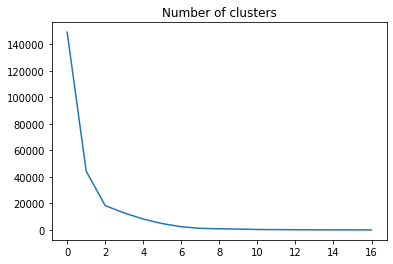

In [19]:
import matplotlib.pyplot as plt

plt.plot(inertias)
plt.title('Number of clusters')
plt.show()

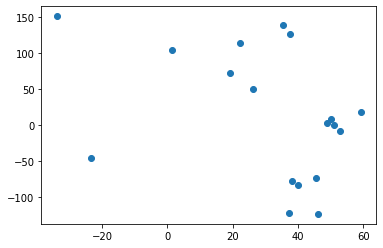

In [20]:
plt.scatter(lat_long.lat,lat_long.lon)

### Do we even need to consider any other features? or are the other features already described by lat long? Is there a statistical measure that can prove this? 

In [21]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()

In [22]:
lat_long = s.fit_transform(lat_long)

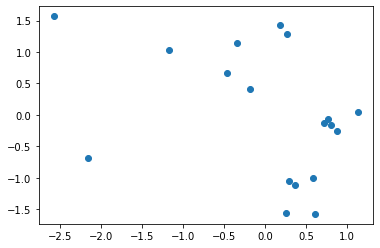

In [23]:
plt.scatter(lat_long[:,0],lat_long[:,1])

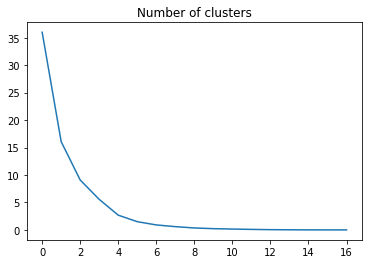

In [24]:
inertias = []

for k in range(1,lat_long.shape[0]):
    model = KMeans(k)
    model.fit(lat_long)
    inertias.append(model.inertia_)
    
plt.plot(inertias)
plt.title('Number of clusters')
plt.show()

### After normalization, we see 8 clusters, explaining the variance the best. This raises a question of why this is happening.

### Are the clusters just the AWS regions? 

In [25]:
len(aws_region_df.region_name.apply(lambda x: x[:2]).unique())

6

#### Thus, after normalization, we get 8 clusters, which might be more informative to the model then just the region.

In [26]:
model = KMeans(8)
model.fit(lat_long)
preds = model.predict(lat_long)

In [27]:
colorMap = {0: 'red',
 1: 'green',
 2: 'blue',
 3: 'black',
 4: 'orange',
 5: 'yellow',
 6: 'pink',
 7: 'maroon'}

In [28]:
preds

array([6, 6, 0, 0, 2, 2, 2, 2, 4, 7, 3, 5, 5, 1, 6, 2, 1, 1], dtype=int32)

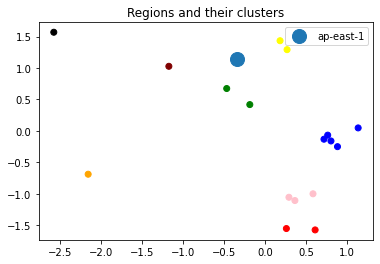

In [29]:
plt.Figure(figsize = (15,20))
plt.scatter(lat_long[:,0],lat_long[:,1],color = [colorMap[c] for c in preds])
plt.title('Regions and their clusters')
plt.plot([-0.33875521],[1.14450522], ls="", marker="o", label="ap-east-1",markersize = 14)
plt.legend(loc = 'best')
plt.show()

In [30]:
src_dest_df.timestamp.min()

Timestamp('2019-12-31 23:00:00+0000', tz='UTC')

In [31]:
src_dest_df.timestamp.max()

Timestamp('2020-03-31 23:00:00+0000', tz='UTC')

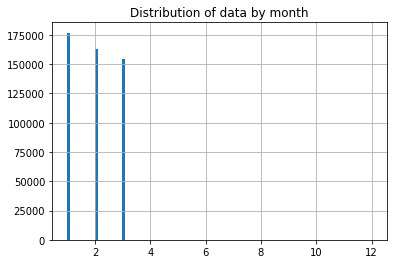

In [32]:
src_dest_df.timestamp.apply(lambda x: x.month).hist(bins = 100)
plt.title('Distribution of data by month')
plt.show()

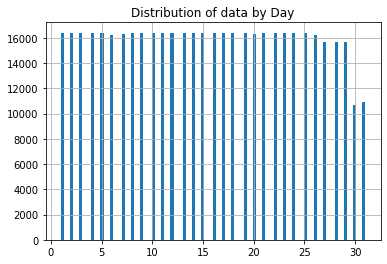

In [33]:
src_dest_df.timestamp.apply(lambda x: x.day).hist(bins =100)
plt.title('Distribution of data by Day')
plt.show()

In [34]:
src_dest_df.timestamp.apply(lambda x: x.year).value_counts() / src_dest_df.timestamp.apply(lambda x: x.year).value_counts().sum()

2020    0.99961
2019    0.00039
Name: timestamp, dtype: float64

### Timestamp variation - The grain of the timeseries prediction must be HOUR

In [35]:
src_dest_df.timestamp.apply(lambda x: x.minute).sum() + src_dest_df.timestamp.apply(lambda x: x.second).sum()

0

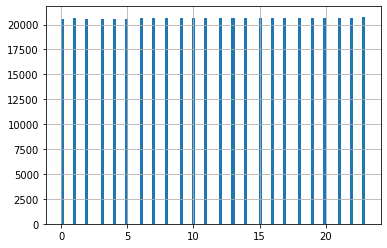

In [36]:
src_dest_df.timestamp.apply(lambda x: x.hour).hist(bins = 100)
plt.show()

####  Thus the prediction problem can be seen as predicting the latency for the ap_east_1 given the predictions of the other regions. i.e For all 5 hour intervals starting January, February , March what are the latencies for the different region combinations - EDA step? 

### Difference between latencies in 2019 and 2020? 

In [37]:
src_dest_df['year'] = src_dest_df.timestamp.apply(lambda x: x.year)

In [38]:
src_dest_df.head()

,timestamp,cloud_geo_iso1,cloud_geo_iso2,latency_ms,packet_loss_percent,year
66,2020-01-01 11:00:00+00:00,AWS.eu-west-1,AWS.ap-northeast-2,124.20,0.0,2020
67,2020-01-01 02:00:00+00:00,AWS.eu-west-1,AWS.ap-southeast-2,131.80,0.0,2020
68,2020-01-08 04:00:00+00:00,AWS.eu-west-1,AWS.ap-northeast-2,123.75,0.0,2020
69,2020-01-17 00:00:00+00:00,AWS.eu-west-1,AWS.eu-west-2,6.35,0.0,2020
70,2020-01-18 03:00:00+00:00,AWS.eu-west-1,AWS.us-west-1,72.35,0.0,2020


In [39]:
src_dest_df[src_dest_df.year == 2019].cloud_geo_iso1.unique()

array(['AWS.eu-west-1', 'AWS.eu-west-2', 'AWS.eu-west-3', 'AWS.sa-east-1',
       'AWS.us-east-1', 'AWS.us-west-1', 'AWS.ap-south-1',
       'AWS.eu-north-1', 'AWS.ca-central-1', 'AWS.eu-central-1',
       'AWS.ap-northeast-2', 'AWS.ap-southeast-1', 'AWS.ap-southeast-2'],
      dtype=object)

### Number of different region combinations

In [40]:
src_dest_df[['cloud_geo_iso1','cloud_geo_iso1']].shape

(495015, 2)

In [41]:
src_dest_df[['cloud_geo_iso1','cloud_geo_iso2']].drop_duplicates()

,cloud_geo_iso1,cloud_geo_iso2
66,AWS.eu-west-1,AWS.ap-northeast-2
67,AWS.eu-west-1,AWS.ap-southeast-2
69,AWS.eu-west-1,AWS.eu-west-2
70,AWS.eu-west-1,AWS.us-west-1
71,AWS.eu-west-1,AWS.eu-north-1
...,...,...
463154,AWS.ap-southeast-2,AWS.eu-west-2
463155,AWS.ap-southeast-2,AWS.ap-northeast-1
463169,AWS.ap-southeast-2,AWS.us-west-2
463182,AWS.ap-southeast-2,AWS.eu-west-3


In [42]:
# Total combinations possible.
18 * 18

324

In [43]:
src_dest_df[src_dest_df.year == 2019][['cloud_geo_iso1','cloud_geo_iso2']].drop_duplicates()

,cloud_geo_iso1,cloud_geo_iso2
5801,AWS.eu-west-1,AWS.us-east-1
7639,AWS.eu-west-1,AWS.ap-southeast-1
10020,AWS.eu-west-1,AWS.eu-west-2
11610,AWS.eu-west-1,AWS.ap-south-1
12076,AWS.eu-west-1,AWS.ca-central-1
...,...,...
476282,AWS.ap-southeast-2,AWS.ap-northeast-1
476948,AWS.ap-southeast-2,AWS.us-east-1
484230,AWS.ap-southeast-2,AWS.eu-west-2
489199,AWS.ap-southeast-2,AWS.ap-northeast-2


In [44]:
193 / 324 

0.595679012345679

###  Thus 2019 does have data for 60% of the actual numbver of combinations, and may be hard to ignore. 

In [45]:
### Thus we could use either city name or region name

len(aws_region_df.city_name.unique())

18

### Preparing training and test dataset

In [46]:
src_dest_df.drop('packet_loss_percent',inplace = True,axis = 1)

In [47]:
aws_region_df

,region_name,city_name,lat,lon
0,us-east-1,Virginia,38.130000,-78.450000
1,us-east-2,Ohio,39.960000,-83.000000
2,us-west-1,California,37.350000,-121.960000
3,us-west-2,Oregon,46.150000,-123.880000
4,eu-west-1,Ireland,53.000000,-8.000000
5,eu-west-2,London,51.000000,-0.100000
6,eu-west-3,Paris,48.860000,2.350000
7,eu-central-1,Frankfurt,50.000000,8.000000
8,sa-east-1,Sao Paulo,-23.340000,-46.380000
9,ap-southeast-1,Singapore,1.370000,103.800000


In [48]:
src_dest_df['cloud_geo_iso2'] = src_dest_df.cloud_geo_iso2.apply(lambda x: x.strip('AWS.'))
src_dest_df['cloud_geo_iso1'] = src_dest_df.cloud_geo_iso1.apply(lambda x: x.strip('AWS.'))

### Correlation between time and latency?

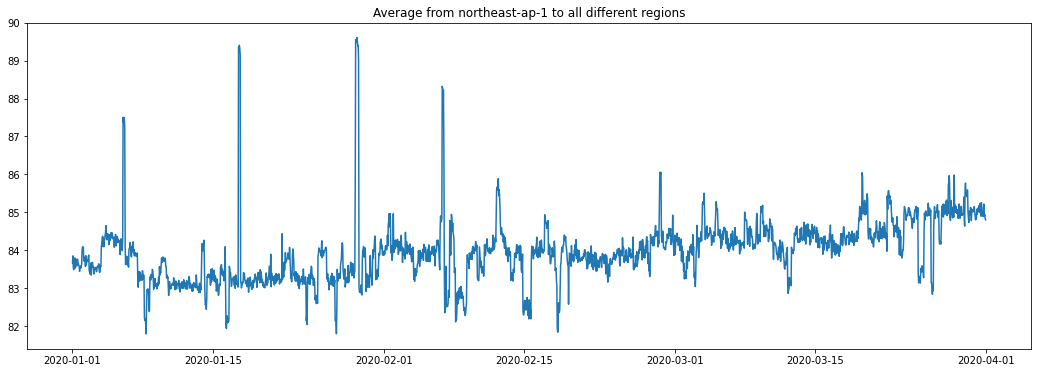

In [76]:
plt.figure(figsize = (18,6))
plt.title('Average from northeast-ap-1 to all different regions')
plt.plot(one_region.groupby('timestamp').mean()['latency_ms'])
plt.show()

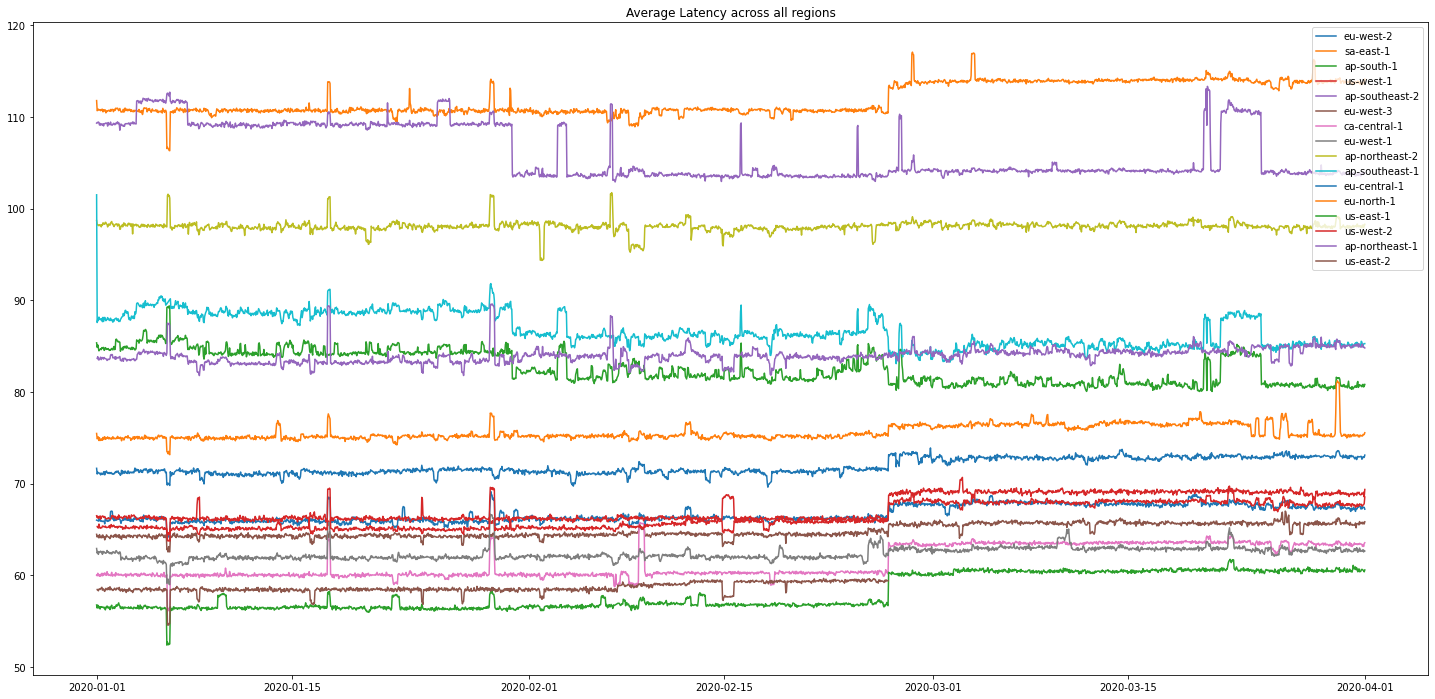

In [82]:
plt.figure(figsize = (25,12))
plt.title('Average Latency across all regions')
for i in src_dest_df.cloud_geo_iso1.unique():
    one_region = src_dest_df[src_dest_df['cloud_geo_iso1'] == i]
    plt.plot(one_region.groupby('timestamp').mean()['latency_ms'],label = i)
plt.legend(loc = 'best')
plt.show()

The outliers in latencies are more clearly visible in these graphs. This can however be dominated by latencies in one region, since we're basically averaging it out over timestamps across multiple regions

### Use color coding to see if latency within cluster is coherent

In [92]:
aws_region_df['clusters'] = preds

In [101]:
modified_src = src_dest_df.set_index('cloud_geo_iso1').join(aws_region_df.set_index('region_name'))
modified_src.reset_index(col_fill = 'cloud_geo_iso1',inplace = True)
modified_src['cloud_geo_iso1'] = modified_src['index']
modified_src.drop('index',axis = 1, inplace = True)

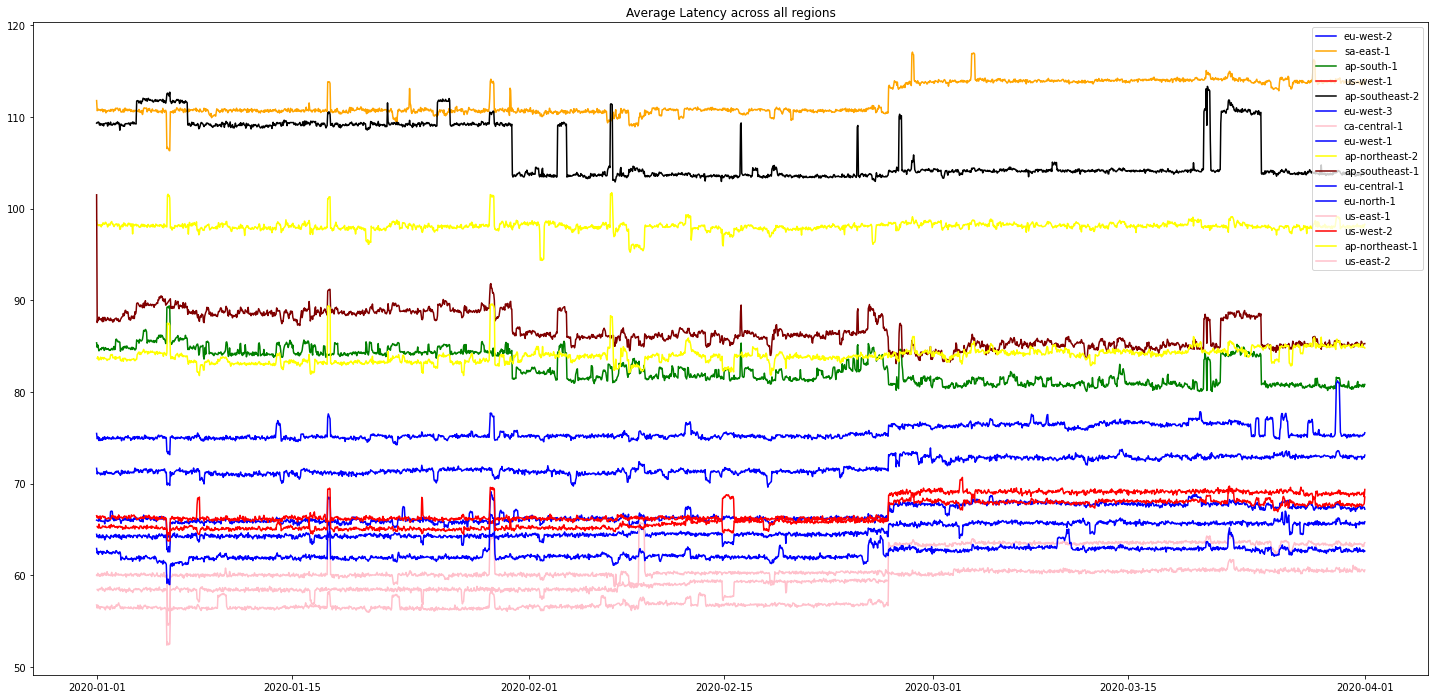

In [112]:
plt.figure(figsize = (25,12))
plt.title('Average Latency across all regions')
for i in src_dest_df.cloud_geo_iso1.unique():
    one_region = modified_src[modified_src['cloud_geo_iso1'] == i]
    plt.plot(one_region.groupby('timestamp').mean()['latency_ms'],label = i , color = colorMap[one_region.clusters.iloc[0]])
plt.legend(loc = 'best')
plt.show()

Strong patterns are present in the time series graph within cluster, and in regions that have more variance, it might be because the continent itself is really large. A distance measure between src and destination would definitely help.

In [57]:
src_dest_df.sort_values('timestamp',ascending = True,inplace = True)

In [123]:
modified_src.drop('city_name',inplace = True,axis = 1)
modified_src.drop('year',inplace = True,axis = 1)

KeyError: "['city_name'] not found in axis"

In [124]:
modified_src.head()

,timestamp,cloud_geo_iso2,latency_ms,lat,lon,clusters,cloud_geo_iso1
0,2020-01-01 00:00:00+00:00,ap-south-1,68.85,35.41,139.42,5,ap-northeast-1
1,2020-01-01 00:00:00+00:00,us-west-1,57.75,35.41,139.42,5,ap-northeast-1
2,2020-01-01 00:00:00+00:00,ca-central-1,79.70,35.41,139.42,5,ap-northeast-1
3,2020-01-01 00:00:00+00:00,us-west-2,51.75,35.41,139.42,5,ap-northeast-1
4,2020-01-01 00:00:00+00:00,eu-west-1,107.95,35.41,139.42,5,ap-northeast-1


### Feature generation attempt for one combiination

In [138]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = dist_one_comb.set_index('timestamp')['latency_ms']
result = seasonal_decompose(series, model='additive')

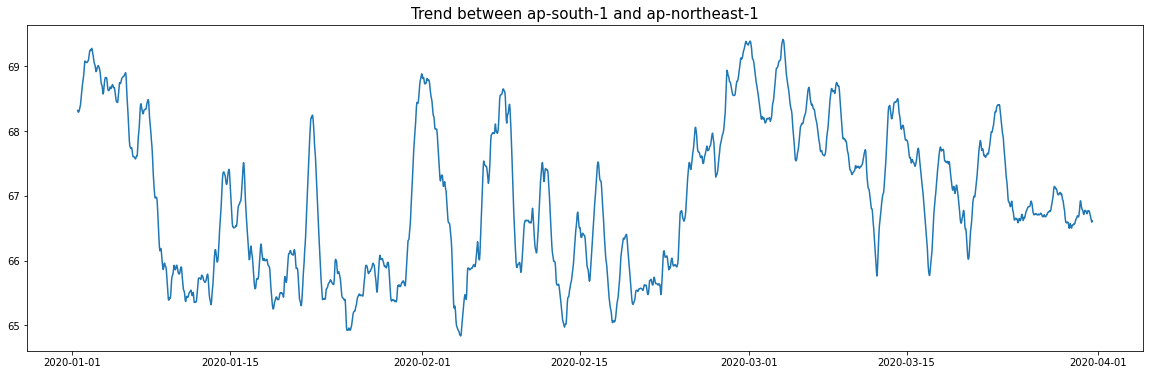

In [148]:
plt.figure(figsize = (20,6))
plt.title('Trend between ap-south-1 and ap-northeast-1',fontsize = 15)
dist_one_comb = modified_src[(modified_src.cloud_geo_iso2 == 'ap-south-1') & (modified_src.cloud_geo_iso1 == 'ap-northeast-1')]
#plt.plot(dist_one_comb['timestamp'],dist_one_comb['latency_ms'])
plt.plot(result.trend)
plt.show()

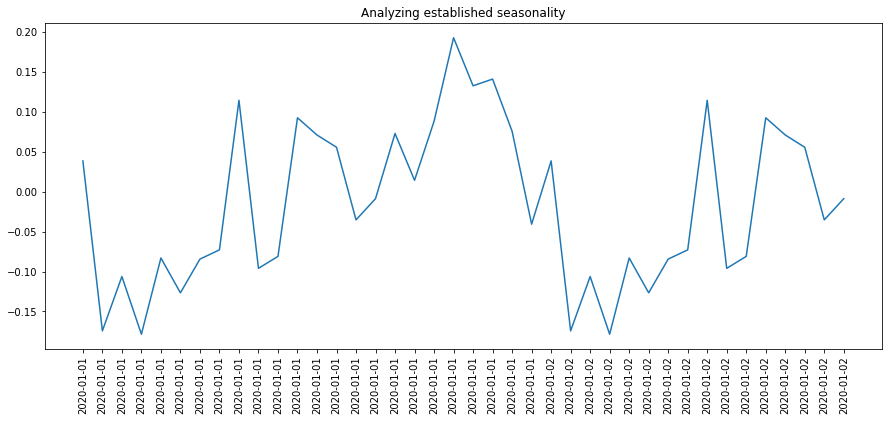

In [165]:
plt.figure(figsize = (15,6))
plt.title('Analyzing established seasonality')
plt.plot(result.seasonal[:40])
plt.xticks(result.seasonal.index[:40],rotation = 90)
plt.show()

Seasonality patterns show that the cycle repeats every 24 hours, which makes sense since most systems and their usages would be following a schedule on the cloud.

### We could also analyze the distribution of seasonality length, and also if, it is constant amongst a cluster, we could use it as a feature.

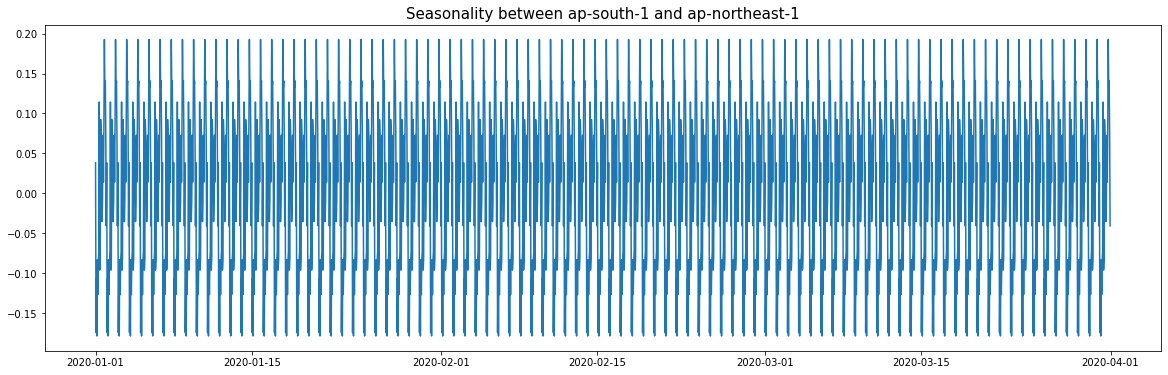

In [172]:
plt.figure(figsize = (20,6))
plt.title('Seasonality between ap-south-1 and ap-northeast-1',fontsize = 15)
dist_one_comb = modified_src[(modified_src.cloud_geo_iso2 == 'ap-south-1') & (modified_src.cloud_geo_iso1 == 'ap-northeast-1')]
#plt.plot(dist_one_comb['timestamp'],dist_one_comb['latency_ms'])
plt.plot(result.seasonal)
plt.show()

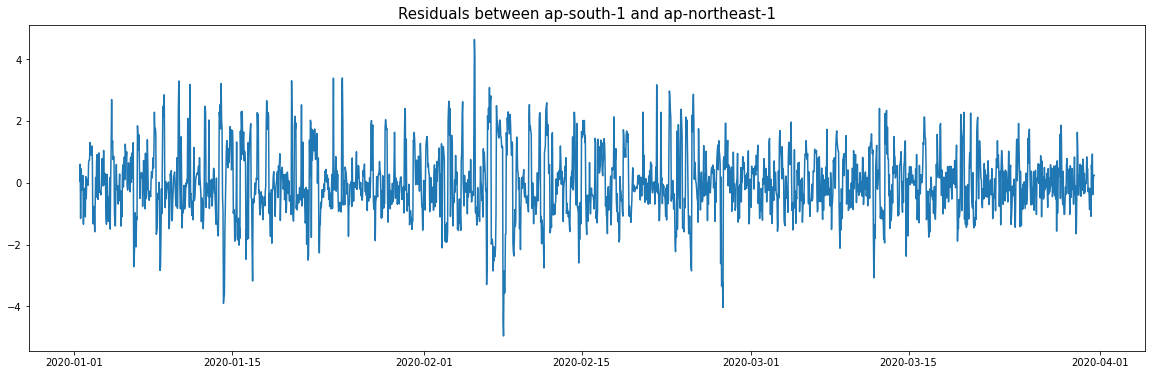

In [171]:
plt.figure(figsize = (20,6))
plt.title('Residuals between ap-south-1 and ap-northeast-1',fontsize = 15)
dist_one_comb = modified_src[(modified_src.cloud_geo_iso2 == 'ap-south-1') & (modified_src.cloud_geo_iso1 == 'ap-northeast-1')]
#plt.plot(dist_one_comb['timestamp'],dist_one_comb['latency_ms'])
plt.plot(result.resid)
plt.show()

The residual time series is stationary, and can be used to calculate features and also for outlier analysis. 
The problem with generating this as features is that during the prediction, the new region will not have any tend at all, making it very difficult for us to generate that feature. 
Our feature generation must thus not be time dependent.

We can however generate trend and seasonality patterns within cluster, and feed it in as a feature

<p> This is not a forecasting problem, it is a machine learning problem with test dataset predictions required. We might have to do some time series decomposition/standardization on the clusters that could make this wave form much more informative then it is. </p>

In [175]:
df = modified_src.set_index('timestamp')

### There can be multiple regions in each cluster, we must get a measure of cluster to cluster latencies as a baseline. 

In [180]:
aws_region_df.head()

,region_name,city_name,lat,lon,clusters
0,us-east-1,Virginia,38.13,-78.45,6
1,us-east-2,Ohio,39.96,-83.00,6
2,us-west-1,California,37.35,-121.96,0
3,us-west-2,Oregon,46.15,-123.88,0
4,eu-west-1,Ireland,53.00,-8.00,2


In [296]:
df = modified_src.set_index('cloud_geo_iso2').join(aws_region_df.set_index('region_name')[['clusters']],rsuffix = '2')

In [297]:
df = df.drop(['cloud_geo_iso1'],axis = 1).reset_index(drop = True)

In [298]:
clusters = []

for i in range(8):
    for j in range(8):
        clusters.append((i,j))

In [299]:
df = df.sort_values('timestamp',ascending = True).set_index(['clusters','clusters2'])

In [289]:
all_clusters = []

for c in clusters:
    try:
        series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
        result = seasonal_decompose(series, model='additive')
        
        features = [result.trend,result.seasonal,result.resid]
        for f in [1,3,12,24,48]:
            temp_f = series.rolling(f).mean()
            temp_f.name = 'ma_' + str(f)
            features.append(temp_f)
        temp_df = pd.concat(features,axis = 1)
        temp_df['clusters'] = c[0]
        temp_df['clusters2'] = c[1]
        temp_df.set_index(['clusters','clusters2'],append = True,inplace = True)
        all_clusters.append(temp_df)
    except Exception as e:
        print('cluster combination not present %d %d'%(c[0],c[1]))

/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact perf

You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
cluster combination not present 0 7
1
cluster combination not present 1 1
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
cluster combination not present 1 7


/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact perf

You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
cluster combination not present 2 7
3
cluster combination not present 3 3
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
cluster combination not present 3 7
4
cluster combination not present 4 4
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
cluster combination not present 4 7


/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact perf

You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
cluster combination not present 5 7
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
cluster combination not present 6 7
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
cluster combination not present 7 0
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
cluster combination not present 7 1
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
cluster combination not present 7 2
You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None
cluster combination not present 7 3
You must specify a period or x must be a pandas object wit

/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  series = df.loc[c[0],c[1]].groupby('timestamp')['latency_ms'].mean()
/tmp/ipykernel_17616/829168048.py:5: PerformanceWarning: indexing past lexsort depth may impact perf

In [522]:
frame_to_join = modified_src.set_index('cloud_geo_iso2').join(aws_region_df[['clusters']],rsuffix = '2').reset_index()

In [523]:
merged = pd.concat(all_clusters)

In [573]:
final_merged = frame_to_join.set_index(['timestamp','clusters','clusters2']).join(merged)

In [574]:
final_merged = final_merged.rename(columns = {'index':'cloud_geo_iso2'}).reset_index()

In [575]:
final_merged.head()

,timestamp,clusters,clusters2,cloud_geo_iso2,latency_ms,lat,lon,cloud_geo_iso1,trend,seasonal,resid,ma_1,ma_3,ma_12,ma_24,ma_48
0,2019-12-31 23:00:00+00:00,0,0,us-west-2,12.15,37.35,-121.96,us-west-1,NaN,0.048763,NaN,12.15,NaN,NaN,NaN,NaN
1,2019-12-31 23:00:00+00:00,0,1,ap-south-1,119.00,37.35,-121.96,us-west-1,NaN,-0.045114,NaN,119.00,NaN,NaN,NaN,NaN
2,2019-12-31 23:00:00+00:00,0,2,eu-central-1,75.80,37.35,-121.96,us-west-1,NaN,0.017429,NaN,75.62,NaN,NaN,NaN,NaN
3,2019-12-31 23:00:00+00:00,0,2,eu-north-1,85.65,37.35,-121.96,us-west-1,NaN,0.017429,NaN,75.62,NaN,NaN,NaN,NaN
4,2019-12-31 23:00:00+00:00,0,2,eu-west-1,73.50,37.35,-121.96,us-west-1,NaN,0.017429,NaN,75.62,NaN,NaN,NaN,NaN


### Generate OOB evaluation set

In [576]:
aws_region_df.index.unique()

Index(['us-east-1', 'us-east-2', 'us-west-1', 'us-west-2', 'eu-west-1',
       'eu-west-2', 'eu-west-3', 'eu-central-1', 'sa-east-1', 'ap-southeast-1',
       'ap-southeast-2', 'ap-northeast-1', 'ap-northeast-2', 'ap-south-1',
       'ca-central-1', 'eu-north-1', 'me-south-1', 'ap-east-1'],
      dtype='object', name='region_name')

In [577]:
combinations = [[]]

for time in final_merged.timestamp.unique():
    for region in aws_region_df.index.unique():
        combinations.append([time,region])

In [578]:
eval_set = pd.DataFrame(combinations,columns = ['timestamp','cloud_geo_iso2'])

In [579]:
eval_set['cloud_geo_iso1'] = 'ap-east-1'

In [580]:
eval_set = eval_set[eval_set['cloud_geo_iso2'] != eval_set['cloud_geo_iso1']]

In [581]:
eval_set = eval_set.dropna()

In [582]:
eval_set = eval_set.set_index('cloud_geo_iso2').join(aws_region_df)[['timestamp','clusters','cloud_geo_iso1']]
eval_set.rename(columns = {'clusters':'clusters2'},inplace= True)
eval_set.reset_index(inplace = True)
eval_set.rename(columns = {'index':'cloud_geo_iso2'},inplace = True)
eval_set = eval_set.set_index('cloud_geo_iso1').join(aws_region_df)[['timestamp','clusters','clusters2','cloud_geo_iso2']]

In [583]:
eval_set.reset_index(inplace = True)
eval_set.rename(columns = {'index':'cloud_geo_iso1'},inplace = True)

In [584]:
eval_set = eval_set.set_index(['timestamp','clusters','clusters2']).join(merged) 

In [585]:
eval_set.reset_index().shape

(37145, 13)

In [586]:
final_merged[(final_merged.cloud_geo_iso1 == 'us-west-2') & (final_merged.cloud_geo_iso2 == 'us-west-1')]

,timestamp,clusters,clusters2,cloud_geo_iso2,latency_ms,lat,lon,cloud_geo_iso1,trend,seasonal,resid,ma_1,ma_3,ma_12,ma_24,ma_48
193,2020-01-01 00:00:00+00:00,0,0,us-west-1,12.75,46.15,-123.88,us-west-2,NaN,0.033745,NaN,12.300,NaN,NaN,NaN,NaN
431,2020-01-01 01:00:00+00:00,0,0,us-west-1,12.35,46.15,-123.88,us-west-2,NaN,-0.024981,NaN,12.450,12.300000,NaN,NaN,NaN
669,2020-01-01 02:00:00+00:00,0,0,us-west-1,12.60,46.15,-123.88,us-west-2,NaN,0.015875,NaN,12.200,12.316667,NaN,NaN,NaN
907,2020-01-01 03:00:00+00:00,0,0,us-west-1,12.90,46.15,-123.88,us-west-2,NaN,-0.051000,NaN,12.725,12.458333,NaN,NaN,NaN
1145,2020-01-01 04:00:00+00:00,0,0,us-west-1,11.80,46.15,-123.88,us-west-2,NaN,-0.011990,NaN,11.800,12.241667,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493975,2020-03-31 19:00:00+00:00,0,0,us-west-1,13.15,46.15,-123.88,us-west-2,NaN,-0.061214,NaN,12.900,12.933333,12.875000,12.845833,12.729687
494183,2020-03-31 20:00:00+00:00,0,0,us-west-1,12.40,46.15,-123.88,us-west-2,NaN,0.046211,NaN,12.200,12.758333,12.843750,12.812500,12.728125
494391,2020-03-31 21:00:00+00:00,0,0,us-west-1,13.15,46.15,-123.88,us-west-2,NaN,-0.028859,NaN,13.300,12.800000,12.897917,12.834375,12.745833
494599,2020-03-31 22:00:00+00:00,0,0,us-west-1,14.70,46.15,-123.88,us-west-2,NaN,0.017414,NaN,13.525,13.008333,12.945833,12.872917,12.766146


In [587]:
final_merged.drop(['lat','lon'],inplace = True,axis = 1)

In [588]:
eval_set['latency_ms'] = np.nan

In [589]:
eval_set = eval_set.reset_index()

In [590]:
final_merged.shape[1] == eval_set.shape[1]

True

In [591]:
final_merged = pd.concat([final_merged,eval_set])

In [592]:
final_merged.shape

(532160, 14)

src_dest_df.set_index('cloud_geo_iso1').join(aws_region_df.set_index('region_name'))

### Time based features

In [593]:
final_merged['year'] = final_merged.timestamp.apply(lambda x: x.year)
final_merged['day'] = final_merged.timestamp.apply(lambda x: x.day)
final_merged['month'] = final_merged.timestamp.apply(lambda x: x.month)
final_merged['hour'] = final_merged.timestamp.apply(lambda x: x.hour)

In [594]:
final_merged.shape

(532160, 18)

### Distance based features

In [595]:
from geopy.distance import distance

In [596]:
distMap = {}

for i in aws_region_df[['lat','lon']].drop_duplicates().to_numpy():
    for j in aws_region_df[['lat','lon']].drop_duplicates().to_numpy():
        distMap[(tuple(i),tuple(j))] = distance(tuple(i),tuple(j)).km

In [597]:
aws_region_df.head(2)

,city_name,lat,lon,clusters
region_name,,,,
us-east-1,Virginia,38.13,-78.45,6
us-east-2,Ohio,39.96,-83.00,6


In [598]:
#aws_region_df.set_index('region_name',inplace = True)
from time import time


def fetchDistance(x):
    points = []
    for i in ['cloud_geo_iso1','cloud_geo_iso2']:
        lat = aws_region_df.loc[x[i]]['lat']
        lon = aws_region_df.loc[x[i]]['lon']
        points.append((lat,lon))
    
    return distMap[(points[0],points[1])]

start = time()
final_merged['distance'] = final_merged.apply(lambda x: fetchDistance(x),axis = 1)
end = time()

In [599]:
transformed = final_merged.groupby(['clusters','clusters2']).transform(lambda x: x.fillna(x.mean()))

/tmp/ipykernel_17616/2236136679.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  transformed = final_merged.groupby(['clusters','clusters2']).transform(lambda x: x.fillna(x.mean()))
/tmp/ipykernel_17616/2236136679.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  transformed = final_merged.groupby(['clusters','clusters2']).transform(lambda x: x.fillna(x.mean()))


In [682]:
complete_dataset = pd.concat([final_merged[['clusters','clusters2','cloud_geo_iso1','cloud_geo_iso2']],transformed],axis = 1)
complete_dataset = complete_dataset.fillna(0)

In [683]:
complete_dataset.isna().sum().sum()

0

In [684]:
complete_dataset.set_index('timestamp',inplace = True)

In [685]:
from category_encoders.one_hot import OneHotEncoder

In [686]:
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([('cloud1',OneHotEncoder(),'cloud_geo_iso1'),
                   ('cloud2',OneHotEncoder(),'cloud_geo_iso2'),
                    ('cluster1',OneHotEncoder(),'clusters'),
                   ('clusters2',OneHotEncoder(),'clusters2')],remainder = 'passthrough')
ct.fit(complete_dataset)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cloud1', OneHotEncoder(), 'cloud_geo_iso1'),
                                ('cloud2', OneHotEncoder(), 'cloud_geo_iso2'),
                                ('cluster1', OneHotEncoder(), 'clusters'),
                                ('clusters2', OneHotEncoder(), 'clusters2')])

In [687]:
complete_dataset[complete_dataset.clusters == 2].cloud_geo_iso1.unique()

array(['eu-central-1', 'eu-north-1', 'eu-west-1', 'eu-west-2',
       'eu-west-3'], dtype=object)

In [688]:
val = complete_dataset[complete_dataset['cloud_geo_iso1'] == 'eu-west-2']
train = complete_dataset[(complete_dataset['cloud_geo_iso1'] != 'eu-west-2') & (complete_dataset['cloud_geo_iso1'] != 'ap-east-1')]
test = complete_dataset[complete_dataset['cloud_geo_iso1'] == 'ap-east-1']

In [689]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

pip = Pipeline([('ct',ct),
                ('ss', StandardScaler()),
                ('rf',RandomForestRegressor())
               ])

pip.fit(train.drop('latency_ms',axis = 1),train['latency_ms'])

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cloud1', OneHotEncoder(),
                                                  'cloud_geo_iso1'),
                                                 ('cloud2', OneHotEncoder(),
                                                  'cloud_geo_iso2'),
                                                 ('cluster1', OneHotEncoder(),
                                                  'clusters'),
                                                 ('clusters2', OneHotEncoder(),
                                                  'clusters2')])),
                ('ss', StandardScaler()), ('rf', RandomForestRegressor())])

In [690]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('MAE %f'%mean_absolute_error(pip.predict(val.drop('latency_ms',axis = 1)),val['latency_ms']))
print('MAPE %f'%mean_absolute_percentage_error(pip.predict(val.drop('latency_ms',axis = 1)),val['latency_ms']))

MAE 2.463680
MAPE 0.051775


This means that we're able to predict within 3 milliseconds of the latencies for this particular region!

### Final predictions

In [691]:
copy = test.copy()
copy['predictions'] = pip.predict(test.drop('latency_ms',axis = 1))

In [692]:
copy.columns

Index(['clusters', 'clusters2', 'cloud_geo_iso1', 'cloud_geo_iso2',
       'latency_ms', 'trend', 'seasonal', 'resid', 'ma_1', 'ma_3', 'ma_12',
       'ma_24', 'ma_48', 'year', 'day', 'month', 'hour', 'distance',
       'predictions'],
      dtype='object')

In [693]:
copy.cloud_geo_iso2.unique()

array(['us-west-1', 'us-west-2', 'ap-south-1', 'me-south-1',
       'eu-central-1', 'eu-north-1', 'eu-west-1', 'eu-west-2',
       'eu-west-3', 'ap-southeast-2', 'sa-east-1', 'ap-northeast-1',
       'ap-northeast-2', 'ca-central-1', 'us-east-1', 'us-east-2',
       'ap-southeast-1'], dtype=object)

/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


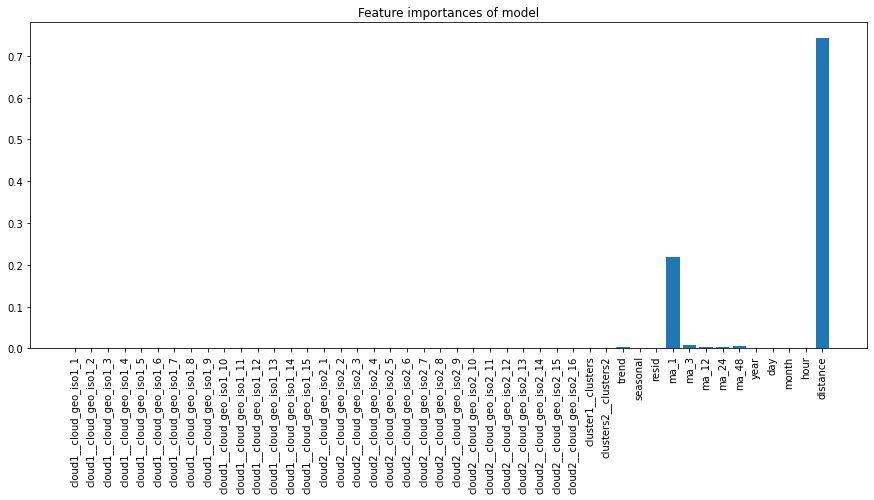

In [701]:
plt.figure(figsize = (15,6))
plt.title('Feature importances of model')
plt.bar(pip[0].get_feature_names(),pip[2].feature_importances_)
plt.xticks(pip[0].get_feature_names(),rotation = 90)
plt.show()

We can see that predictions are majorly dominated by distance and moving average, which makes sense. 

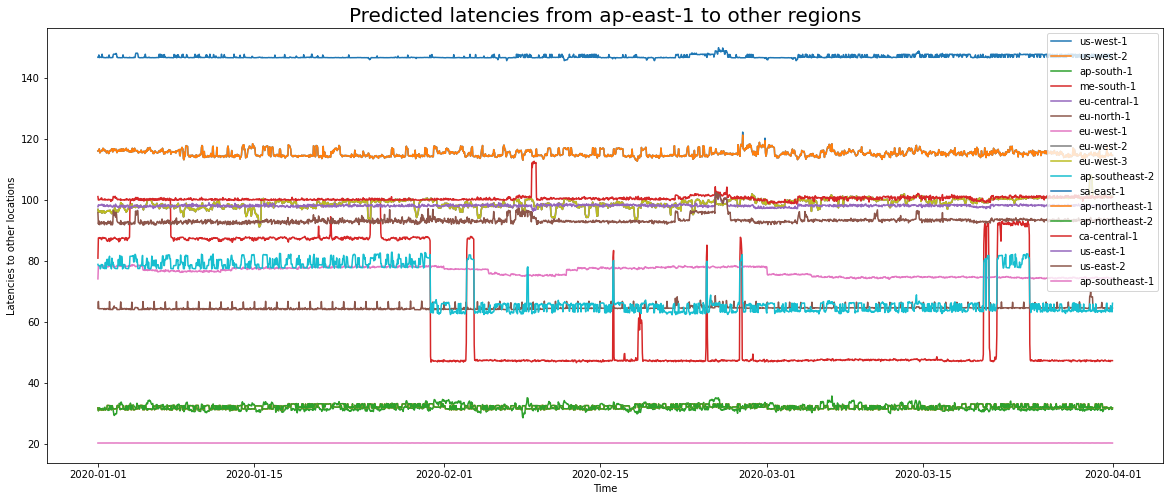

In [698]:
plt.figure(figsize = (20,8))
plt.title('Predicted latencies from ap-east-1 to other regions',fontsize = 20)

for c in copy.cloud_geo_iso2.unique():
    plt.plot(copy[copy['cloud_geo_iso2'] == c]['predictions'],label = c)

plt.xlabel('Time')
plt.ylabel('Latencies to other locations')
plt.legend(loc = 'best')
plt.show()

# Part 2: Outlier detection

For outlier detection, we use use the same model to further predict the absolute percentages

In [703]:
actuals = train['latency_ms']
preds = pip.predict(train.drop('latency_ms',axis = 1))

### Calculate 95% confidence interval for predictions

In [714]:
sum_of_errors = ((actuals - preds) **2).sum()
stdev = np.sqrt(1/(len(actuals)-2) * sum_of_errors)

In [717]:
interval = stdev * 1.96

In [ ]:
### We use the standard deviation of the actual population to calculate

In [721]:
lower, upper = preds - interval, preds + interval

In [726]:
train[(actuals < lower) | (actuals > upper)][['latency_ms','cloud_geo_iso1','cloud_geo_iso2']]

,latency_ms,cloud_geo_iso1,cloud_geo_iso2
timestamp,,,
2019-12-31 23:00:00+00:00,119.00,us-west-1,ap-south-1
2019-12-31 23:00:00+00:00,98.20,us-west-1,sa-east-1
2019-12-31 23:00:00+00:00,61.30,ap-south-1,eu-central-1
2019-12-31 23:00:00+00:00,56.50,ap-south-1,eu-west-2
2019-12-31 23:00:00+00:00,33.15,ap-south-1,ap-southeast-1
...,...,...,...
2020-03-31 23:00:00+00:00,41.90,us-west-2,us-east-1
2020-03-31 23:00:00+00:00,59.25,eu-north-1,ca-central-1
2020-03-31 23:00:00+00:00,82.45,eu-west-3,ap-southeast-1


Thus , we have identified outliers effectively, with a strict confidence interval. As we decrease the confidence interval , the number of outliers should increase. 

<u> Distribution of outlier values </u>

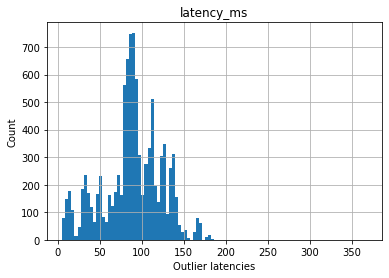

In [730]:
train[(actuals < lower) | (actuals > upper)][['latency_ms']].hist(bins = 100)
plt.xlabel('Outlier latencies')
plt.ylabel('Count')
plt.show()